# Structure Learning in Bayesian Networks

A Bayesian Network (BN) is a graphical representation of the probabilistic relationships among a set of variables. The challenge of structure learning in Bayesian networks is to find the best network structure (directed acyclic graph) that explains the observed data.

In the Bayesian approach, we treat the network structure as a random variable and compute the posterior distribution of structures given the observed data. The most probable structure given the data is then selected as the best structure. Mathematically:

$$P(G | D) = \frac{P(D | G) P(G)}{P(D)}$$

Where:
- $P(G | D)$ is the posterior probability of structure $G$ given data $D$.
- $P(D | G)$ is the likelihood of data $\left( D \right)$ given structure $G$ (this is the marginal likelihood we're interested in).
- $P(G)$ is the prior probability of structure \left( G \right).
- $P(D)$ is the probability of the data, also known as the marginal likelihood of the data, which acts as a normalizing constant.

The objective is to maximize $P(G | D)$, which is equivalent to maximizing $P(D | G) P(G)$, since $P(D)$ is constant for all structures.

## Marginal Likelihood

To compute $P(D | G)$, we need to integrate over all possible parameter values:

$$P(D | G) = \int P(D | \theta, G) P(\theta | G) d\theta$$

Where:
- $\theta$ represents the parameters of the Bayesian network (e.g., conditional probabilities in discrete BNs or regression coefficients in Gaussian BNs).
- $P(D | \theta, G)$ is the likelihood of the data given the parameters and the structure.
- $P(\theta | G)$ is the prior distribution of the parameters given the structure.

## The Case of Gaussian Bayesian Networks

We define a Gaussian Bayesian network to be a Bayesian network all of whose variables are continuous, and where all of the CPDs are linear Gaussians.



### Marginal Likelihood

Consider a single node $Y$ in a Gaussian Bayesian network with parents $Pa(Y)$. Given the Gaussian Bayesian network assumptions:

- $Y$ is linearly dependent on its parents $Pa(Y)$ with some Gaussian noise.
- The relationship is given by:


$$Y = \boldsymbol{\beta}^T Pa(Y) + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma^2)$$

Where:
- $\boldsymbol{\beta}$ is a vector of regression coefficients.
- $\sigma^2$ is the variance of the error term $\epsilon$.

### Priors:

For Bayesian inference, we need priors on our parameters:

1. $\beta$ has a multivariate normal prior:

$$\beta \sim \mathcal{N}(\mathbf{0}, \sigma^2 \Lambda_0^{-1})$$

Here, $\Lambda_0$ is the prior precision matrix (inverse of the covariance matrix) for $\beta$.

2. $\sigma^2$ has an inverse gamma prior:

$$\sigma^2 \sim \text{Inv-Gamma}(a_0, b_0)$$

Where $a_0$ and $b_0$ are the shape and scale parameters, respectively.

### Computing the Marginal Likelihood:

The marginal likelihood is obtained by integrating out the parameters $\beta$ and $\sigma$:

$$P(Y | \textbf{Pa}(Y), G) = \int \int P(Y | \boldsymbol{\beta}, \sigma^2, \textbf{Pa}(Y), G) P(\boldsymbol{\beta} | \sigma^2, G) P(\sigma^2 | G) \, d\boldsymbol{\beta} \, d\sigma^2$$

Given our assumptions, this integral simplifies considerably:

- The likelihood $P(Y | \beta, \sigma^2, Pa(Y), G)$ is a normal distribution.
- The prior $P(\beta | \sigma^2, G)$ is also a normal distribution.
- The prior $P(\sigma^2 | G)$ is an inverse gamma distribution.

The product of two normal distributions is another normal distribution. The product of a normal and an inverse gamma distribution is a multivariate Student's t-distribution.

Given this, the integral can be solved analytically, leading to the formula:

$$
P(Y | G) = \frac{1}{(2\pi)^{n/2}} \sqrt{\frac{\det(\Lambda_0)}{\det(\Lambda_n)}} \cdot \frac{b_0^{a_0}}{b_n^{a_n}} \cdot \frac{\Gamma(a_n)}{\Gamma(a_0)}
$$

Where:
- $ \Lambda_n$ is the updated precision matrix after observing the data.
- $a_n$ and $b_n$ are the updated parameters of the inverse gamma distribution after observing the data.

### Computing the Log Marginal Likelihood

Taking the natural logarithm of both sides, we get the log marginal likelihood:

$$\log(p(Y | G)) = -\frac{n}{2} \log(2\pi) + \frac{1}{2} \left( \log\det(\Lambda_0) - \log\det(\Lambda_n) \right) + a_0 \log(b_0) - a_n \log(b_n) + \log\Gamma(a_n) - \log\Gamma(a_0)$$


### Pseudocode

**Input:** 
- Dataset \( D \)
- Bayesian Network Graph \( G \)

**Output:** 
- Marginal Log Likelihood

---

**Function** `ComputeLogMarginalLikelihood(D, G)`

1. Let $n$ be the number of data points in $D$
2. Initialize hyperparameters for $\sigma^2$:
    - $a_0 = 1$
    - $b_0 = 1$
3. Initialize `total_log_ml = 0`
4. For each node $X_i$ in $G$:
    1. If $X_i$ has parents (is not a root):
        1. Extract data for the node as $y$
        2. Extract data for the node's parents as matrix $X$
        3. Let $p$ be the number of predictors for $X_i$
        4. Set up the Priors for $\beta$:
            - $\Lambda_0 = I_p$ (Prior precision matrix of size $p \times p$)
            - $m_0 = 0_p$ (Prior mean vector of length $p$)
        5. Compute Posterior Precision Matrix for $\beta$:
            - $\Lambda_n = \Lambda_0 + X^T \cdot X$
        6. Compute Posterior Mean for $\beta$:
            - $m_n = \Lambda_n^{-1} ( \Lambda_0 m_0 + X^T y )$
        7. Compute residuals $r$ as:
            - $r = y - X \cdot m_n$
        8. Compute Residual Sum of Squares (RSS) as:
            - $RSS = \sum r_i^2$
        9. Update hyperparameters for $\sigma^2$:
            - $a_n = a_0 + \frac{n}{2}$
            - $b_n = b_0 + RSS / 2$
        10. Compute Marginal Log Likelihood for the node using:
            $$\log(p(D|G)) = - \frac{n}{2} \log(2\pi) + \frac{1}{2} (\log |\Lambda_0| - \log |\Lambda_n|) + a_0 \log(b_0) - a_n \log(b_n) + \Gamma(a_n) - \Gamma(a_0)$$
            
        11. Accumulate to `total_log_ml`
5. **Return** `total_log_ml`

---

**Function** `ComputeMarginalLikelihood(D, G)`

1. Compute $\log(p(D|G))$ using `ComputeLogMarginalLikelihood(D, G)`
2. **Return** $e^{\log(p(D|G))}$

---

This pseudocode provides a mathematical representation of the algorithm to compute the marginal log likelihood for a linear Gaussian Bayesian network.



### References 

- Bayesian Linear Regression, Wikipedia (https://en.wikipedia.org/wiki/Bayesian_linear_regression)
- David Heckerman and Dan Geiger, "Likelihoods and Parameter Priors for Bayesian Networks", arxiv, 2021 (https://arxiv.org/pdf/2105.06241.pdf)
- Jack Kuipers, Giusi Moffa and David Hackerman, "Addendum on the Scoring of the Gaussian Directed Acyclic Graphical Models", The Annals of Statistiscs, 42, 1689-1891, 2014
- Jack Kuipers, Giusi Moffa and David Hackerman, "Addendum on the Scoring of the Gaussian Directed Acyclic Graphical Models (Suplementary Material)", The Annals of Statistiscs, 42, 1689-1891, 2014
- Gregory Gundersen, Bayesian Linear Regression, https://gregorygundersen.com/blog/2020/02/04/bayesian-linear-regression/



## Example with 2 Gaussian Random Variables

Let $G$ be the skeleton of a Linear Gaussian Bayesian Network and $D$ a dataset. Consider that $G:~X_1 \rightarrow X_2$ and $D$ is a $2 \times 2$ matrix:

$$D = \left( \begin{matrix} 1 & 2 \\
                            3 & 4 \end{matrix} \right)$$

### 1. Dataset setup

Let's split $D$ into

$$X = \left( \begin{matrix} 1 \\ 3  \end{matrix}  \right) ~~~~~~~ y = \left( \begin{matrix} 2 \\ 4  \end{matrix}  \right)$$

where $X$ corresponds to the values of $X1$ and $y$ to the values of $X_2$.

### 2. Model Setup

We have the following regression model:

$$y = \beta X + \epsilon$$

where $\beta$ is the regression coefficients and $\epsilon$ is the error term $\epsilon \sim \mathcal{N}(0, 1)$


### 3. Setting up the Priors

For the regression coefficients $\beta$, we assume: 

$$ \beta \sim \mathcal{N}( m_0, \Lambda_0^{-1})$$

For $\sigma^2$ (variance of the regression errors), we assume an inverse Gamma distribution:

$$ \sigma^2 \sim Inv-Gamma(a_0, b_0)$$

Let's choose some arbitrary values for our priors:

- $m_0$: vector with zeros of the same size as the number of predictors (in this case, $X_1$). So, $m_0 = \left( \begin{matrix} 0 \end{matrix} \right)$
- $\Lambda_0$: identity matrix of size $1 \times 1$ (in this case, it is a scalar)
- $a_0$: arbitrary choice. We will choose $a_0 = 1$ for simplicity
- $b_0$: arbitrary choice. We will choose $b_0 = 1$ for simplicity

### 3. Compute $\Lambda_n$ and $m_n$ for $\beta$

We update $Lambda_n$ and $m_n$ using the following formulas:

$$\Lambda_n = \Lambda_0 + X^TX = 1 + \left( \begin{matrix} 1 & 3 \end{matrix} \right) \left( \begin{matrix} 1 \\ 3 \end{matrix} \right) = 1 + 10 = 11$$
$$m_n = \Lambda_n^{-1} \left(  \Lambda_0 m_0 + X^T y \right) = \frac{1}{11} \left(  1 \left( 0 \right) + \left( \begin{matrix} 1 & 3 \end{matrix} \right)  \left( \begin{matrix} 2 \\ 4 \end{matrix} \right) \right) = \frac{1}{11} \left( 0 + 14 \right) = \frac{14}{11}$$

### 4.  Compute $a_n$ and $b_n$ for $\sigma^2$

We update $a_n$ and $b_n$ using the following formulas:

$$a_n = a_0 + \frac{n}{2} = 1 + \frac{2}{2} = 2$$

$$b_n = b_0 + \frac{1}{2} RSS$$

Where RSS is the Residual Sum of Squares. The residuals can be computed by making the difference between the observed and the predicted values for each data point:

$$RSS = \sum_i^n  (y_i - m_n X_i)^2$$

$$RSS = ( 2 - \frac{14}{11} \times 1 )^2 + ( 4 - \frac{14}{11} \times 3 )^2 = 0.5289 + 0.0331 = 0.5620$$

In matrix form:
$$RSS = (y - X m_n)^T (y - X m_n) = \left(  \left(\begin{matrix} 2 \\ 4 \end{matrix} \right) - \left( \begin{matrix} 1 \\ 3 \end{matrix} \right)  \frac{14}{11}  \right)^T  \left(  \left(\begin{matrix} 2 \\ 4 \end{matrix} \right) - \left( \begin{matrix} 1 \\ 3 \end{matrix} \right)  \frac{14}{11}  \right) =  \left( \begin{matrix} 2 - \frac{14}{11} & 4 - \frac{3 \times 14}{11} \end{matrix} \right)  \left( \begin{matrix} 2 - \frac{14}{11} \\ 4 - \frac{3 \times 14}{11} \end{matrix} \right) =  \left( 2 - \frac{3 \times 14}{11} \right)^2 + \left( 4 - \frac{3 \times 14}{11} \right)^2 = 0.5620 $$

Leading to 

$$b_n = 1 + \frac{0.5620}{2} = 1.2810$$

### 5. Compute the Marginal Likelihood:

Having all the parameters $a_0$, $a_n$, $m_0$, $m_n$, $b_0$, $b_n$ and $\Lambda_0$, $\Lambda_1$, then the Marginal Likelihood becomes:

$$
P(y | X) = \frac{1}{(2\pi)^{n/2}} \sqrt{\frac{\det(\Lambda_0)}{\det(\Lambda_n)}} \cdot \frac{b_0^{a_0}}{b_n^{a_n}} \cdot \frac{\Gamma(a_n)}{\Gamma(a_0)}
$$

$$
P(y | X) = \frac{1}{(2\pi)^{2/2}} \sqrt{\frac{\det(1)}{\det(11)}} \cdot \frac{1^{1}}{1.2810^{2}} \cdot \frac{\Gamma(2)}{\Gamma(1)} = \frac{1}{2\pi} \sqrt{\frac{1}{11}} \cdot \frac{1}{1.640961} \cdot \frac{1}{1} = 0.02924324
$$

**Question: can I consider the marginal likelihood as**
$$
P(y | X) \approx  \sqrt{\frac{\det(\Lambda_0)}{\det(\Lambda_n)}} \cdot \frac{b_0^{a_0}}{b_n^{a_n}} \cdot \frac{\Gamma(a_n)}{\Gamma(a_0)} 
$$

This would give a "better number" to work with:

$$
P(y | X) \approx \sqrt{\frac{\det(\Lambda_0)}{\det(\Lambda_n)}} \cdot \frac{b_0^{a_0}}{b_n^{a_n}} \cdot \frac{\Gamma(a_n)}{\Gamma(a_0)}  = 0.1837407
$$


### 6. Compute the Log Marginal Likelihood:

$$\log(p(\mathbf{y} | X)) = -\frac{n}{2} \log(2\pi) + \frac{1}{2} \left( \log \det(\Lambda_0) - \log\det(\Lambda_n) \right)\\ + a_0 \log(b_0) - a_n \log(b_n) + \log\Gamma(a_n) - \log\Gamma(a_0)$$

$$\log(p(\mathbf{y} | X)) = -\frac{1}{2}\log(2\pi) + \frac{1}{2} \left( \log 1 - \log 11 \right) + 1 \log 1 - 2 \log(1.640961) + \log 1 - \log 1 \\=  -\frac{1}{2}\log(2\pi) - \frac{\log 11}{2} - 2 \log(1.640961) = -3.5321068 $$

## Score Functions

### Imports

In [303]:
import pandas as pd
import numpy as np
import networkx as nx
import arviz as az

import matplotlib.pyplot as plt

from scipy.stats import norm
from sklearn.linear_model import LinearRegression

import itertools
import random

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

from scipy.special import gamma
from scipy.special import gammaln

import xarray as xr


from scipy.linalg import block_diag

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

from pgmpy.models import BayesianModel, BayesianNetwork
from pgmpy.estimators import ParameterEstimator, BicScore

from scipy.special import gammaln, multigammaln
from numpy.linalg import det, inv

from itertools import chain, combinations

from scipy.stats import invgamma, multivariate_normal


### Marginal Likelihood

In [337]:
def compute_log_marginal_likelihood(df: pd.DataFrame, G: nx.DiGraph):
    n, _ = df.shape  

    # For sigma^2
    a0 = 1
    b0 = 1

    total_log_ml = 0
    parameters = {}  # Dictionary to store the parameters for each node

    N = len(df) 
    
    # Loop through each node in the graph
    for node in G.nodes():
        # Extract the data for the node
        y = df[node].values
        
        # If the node has parents
        if G.in_degree(node) > 0:
            # Extract the data for the node and its parents
            X = df[list(G.predecessors(node))].values
        else:
            # For root nodes, X is just an intercept term
            X = np.ones((len(y), 1))
        
        # If the node is not a root node, add the intercept term
        if G.in_degree(node) > 0:
            X = np.concatenate((np.ones((X.shape[0],1)), X), axis=1)
            
        p_node = X.shape[1]     # Number of predictors for this node + intercept
        # Setting up the Priors for beta
        Lambda0 = np.eye(p_node)*0.1   # Prior precision matrix
        m0 = np.zeros(p_node)     # Prior mean vector
        
        # Bayesian Linear Regression
        # Compute the posterior precision matrix Lambda_n for beta
        Lambda_n = Lambda0 + X.T @ X

        # Compute the posterior mean m_n for beta
        m_n = np.linalg.inv(Lambda_n) @ (Lambda0 @ m0 + X.T @ y)

        # Compute a_n and b_n for sigma^2
        a_n = a0 + N/2
        b_n = b0 + 0.5 * ( y.T @ y + m0 @ Lambda0 @ m0 - m_n.T @ Lambda_n @ m_n  )
        
        # Save the parameters for the node
        parameters[node] = {
            'Lambda_n': Lambda_n,
            'm_n': m_n,
            'a_n': a_n,
            'b_n': b_n
        }

        # Compute the Marginal Likelihood for this node and add to total
        log_ml_node = ( - (len(y)/2) * np.log(2*np.pi) 
                        + 0.5 * (np.linalg.slogdet(Lambda0)[1] - np.linalg.slogdet(Lambda_n)[1]) 
                        + a0 * np.log(b0) - a_n * np.log(b_n) + gammaln(a_n) - gammaln(a0) )
        total_log_ml += log_ml_node
    
    return total_log_ml, parameters


def compute_marginal_likelihood(df: pd.DataFrame, G: nx.DiGraph):
    return np.exp(compute_log_marginal_likelihood(df, G))


In [338]:
compute_log_marginal_likelihood(data2, initial_graph)

(-2875.4381611968624,
 {'X1': {'Lambda_n': array([[2000.1]]),
   'm_n': array([0.97573036]),
   'a_n': 1001.0,
   'b_n': 1468.989851919527},
  'X2': {'Lambda_n': array([[2000.1       , 1951.55828473],
          [1951.55828473, 4840.27436345]]),
   'm_n': array([-0.57895159,  0.56015936]),
   'a_n': 1001.0,
   'b_n': 550.2983783502953},
  'X3': {'Lambda_n': array([[2000.1       , 1951.55828473,  -64.77743533],
          [1951.55828473, 4840.27436345, 1581.46722202],
          [ -64.77743533, 1581.46722202, 2022.0734252 ]]),
   'm_n': array([-1.10473912,  1.10559577, -0.88561253]),
   'a_n': 1001.0,
   'b_n': 4.265469660288886}})

In [307]:

def sample_parameters(parameters):
    sampled_values = {}
    for node, param in parameters.items():
        # Sample sigma^2 from the inverse gamma distribution
        sigma2 = invgamma.rvs(a=param['a_n'], scale=param['b_n'])

        # Sample beta from the multivariate normal distribution
        cov_matrix = sigma2 * np.linalg.inv(param['Lambda_n'])
        beta = multivariate_normal.rvs(mean=param['m_n'], cov=cov_matrix)

        sampled_values[node] = {
            'beta': beta,
            'sigma2': sigma2
        }

    return sampled_values


## Likelihood

 The likelihood function for a linear Gaussian Bayesian network is derived from the normal distribution's probability density function (PDF). The likelihood $P(D | G)$ is given by the following equation

\begin{equation}
    P(D | G) = \int P(D | \theta, G) P(\theta | G) d\theta
\end{equation}

Where:
- $\theta$ represents the parameters of the Bayesian network (e.g., conditional probabilities in discrete BNs or regression coefficients in Gaussian BNs).
- $P(D | \theta, G)$ is the likelihood of the data given the parameters and the structure.
- $P(\theta | G)$ is the prior distribution of the parameters given the structure.

### Likelihood of a single node in a Gaussian Bayesian network

Given a node $X_i$ and its parents $Pa(X_i)$, the relationship can be described as:

$$X_i = \beta_0 + \sum_{j} \beta_j Pa (X_i)_j + \epsilon$$

Where $\beta_0$ is the intercept term, $\beta_j$ are the coefficients for each parent $\epsilon$ is the error term which is normally distributed with mean 0 and variance $\sigma^2$.

The likelihood of observing a particular data point $x_i$ given its parents $Pa(x_i)$ and the parameters $\beta$ and $\sigma^2$ is:

$$P(x_i | Pa(x_i), \beta, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left( -\frac{(x_i - (\beta_0 + \sum_j \beta_j  Pa(x_i)_j))^2}{2\sigma^2} \right)$$

Given a dataset, the likelihood for all data points is the product of the likelihood for each data point:

$$P(D | \beta, \sigma^2) = \prod_i p(x_i | Pa (x_i), \beta, \sigma^2)$$

### Likelihood for the entire network

For the entire Bayesian network, the likelihood is the product of the likelihoods for each node given its parents:

$$p(D | G, \Theta) = \prod_{i} p(D_{X_i} | Pa(X_i), \Theta_{X_i})$$

Where $D$ is the entire dataset, $G$ is the graph structure, $\Theta$ represents all the parameters in the network, $D_{X_i}$ is the data corresponding to node $X_i$, and $\Theta_{X_i}$ are the parameters associated with node $X_i$.

### Pseudocode

**Input:** 
- Dataset \( D \)
- Bayesian Network Graph \( G \)
- Parameters \( \Theta \)

**Output:** 
- Likelihood \( P(D | G, \Theta) \)

---

**Function** `ComputeLikelihood(D, G, Θ)`

1. Initialize `total_likelihood = 1`
2. For each node $X_i$ in $G$:
    1. Retrieve parameters $\beta, \sigma^2$ for $X_i$ from $\Theta$
    2. Initialize `node_likelihood = 1`
    3. For each data point $x_i$ in $D_{X_i}$:
        1. Compute parents' data `Pa(x_i)`
        2. Calculate $\mu = \beta_0 + \sum_j \beta_j \times Pa(x_i)_j$
        3. Compute likelihood for data point:
        
        
        $$p(x_i) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left( -\frac{(x_i - \mu)^2}{2\sigma^2} \right)$$
        
        4. Update `node_likelihood = node_likelihood * p(x_i)`
    4. Update `total_likelihood = total_likelihood * node_likelihood`

3. **Return** `total_likelihood`

---

In [308]:
def log_likelihood_bn(df, G):
    total_log_likelihood = 0.0
    
    # For each node in the graph
    for node in G.nodes():
        # Extract the data for the node
        y = df[node].values
        
        # If the node has parents (is not a root)
        if G.in_degree(node) > 0:
            # Extract the data for the node's parents
            X = df[list(G.predecessors(node))].values
            
            # Fit a linear regression model
            reg = LinearRegression().fit(X, y)
            
            # Compute the predicted values
            y_pred = reg.predict(X)
            
            # Compute the residuals
            residuals = y - y_pred
            
            # Compute the variance of residuals (our estimated sigma^2)
            sigma2 = np.var(residuals)
            
            # Compute the log likelihood for this node
            node_log_likelihood = (-0.5 * np.log(2 * np.pi * sigma2)) - (residuals**2 / (2 * sigma2))
            
            # Add to the total log likelihood
            total_log_likelihood += np.sum(node_log_likelihood)
            
        # If the node is a root, we assume a simple Gaussian likelihood
        else:
            mean = np.mean(y)
            sigma2 = np.var(y)
            
            root_log_likelihood = (-0.5 * np.log(2 * np.pi * sigma2)) - ((y - mean)**2 / (2 * sigma2))
            total_log_likelihood += np.sum(root_log_likelihood)
    
    return total_log_likelihood


### BGe Score

Let $m^h$ be the model hypothesis that the true distribution 


The BGe (Bayesian Gaussian equivalence) score in the context of Gaussian Bayesian networks, provides a measure of how well a given network structure explains the observed data, taking into account the complexity of the network.

The BGe score is derived from the marginal likelihood of the data given the network structure, and it incorporates priors over both the structure and the parameters.

More formally, given a node $X_i$ and its parents $Pa(X_i)$, the BGe score component for this node (given its parents) is the marginal likelihood of the data for $X_i$ and $Pa(X_i)$. This marginal likelihood integrates out the parameters: the regression coefficients $\beta_i$ and the error variance $\sigma^2_i$. 

Using a conjugate prior setup, where $\beta_i$ has a multivariate normal prior and $\sigma^2_i$ has an inverse gamma prior, the marginal likelihood is:

$$p(D_i | G ) = $$

Ref: Addendum on the scoring of gaussian directed acyclic gahical models
Kuipers Moffa and heckerman

Sumu : a Python library for working with probabilistic and causal graphical models (https://github.com/jussiviinikka/sumu/tree/master)

In [309]:


def BGe_score(df, G):
    """Compute the BGe score for a Gaussian Bayesian network structure G given data df."""
    pass

### AIC

The Akaike Information Criterion (AIC) is a metric used to compare different models in terms of their goodness of fit and complexity. For linear regression models, the AIC is defined as:

$$\text{AIC} = 2k - 2\ln(L)$$

Where:
- $\left( k \right)$ is the number of parameters in the model.
- $\left( L \right)$ is the maximum likelihood value of the model.



In [310]:
def AIC_score(df: pd.DataFrame, G: nx.DiGraph):
    # Compute the log-likelihood using the provided log-likelihood function
    log_likelihood = log_likelihood_bn(df, G)
    
    # Count the number of parameters in the model
    k = 0
    for node in G.nodes():
        num_parents = G.in_degree(node)
        
        # Add the number of regression coefficients for this node (including intercept)
        k += num_parents + 1
        
        # Add one for the error variance of this node
        k += 1

    # Compute the AIC score
    AIC = -2 * log_likelihood + 2 * k
    
    return AIC


### BIC

The Bayesian Information Criterion (BIC), also known as the Schwarz Information Criterion, is similar to the AIC but has a different penalty term for model complexity. The BIC is defined as:

$$\text{BIC} = k \ln(n) - 2\ln(L)$$

Where:
- $\left( k \right)$ is the number of parameters in the model.
- $\left( n \right)$ is the number of data points.
- $\left( L \right)$ is the maximum likelihood value of the model.



In [311]:
def BIC_score(df: pd.DataFrame, G: nx.DiGraph):
    n, _ = df.shape
    
    # Compute the log-likelihood using the provided log-likelihood function
    log_likelihood = log_likelihood_bn(df, G)
    
    # Count the number of parameters in the model
    k = 0
    for node in G.nodes():
        num_parents = G.in_degree(node)
        
        # Add the number of regression coefficients for this node (including intercept)
        k += num_parents + 1
        
        # Add one for the error variance of this node
        k += 1

    # Compute the BIC score
    BIC = -2 * log_likelihood + k * np.log(n)
    
    return BIC


## Structure MCMC

Pseudocode for implementing the Metropolis-Hastings algorithm for structure learning in graphs:

```python
Initialize a graph G
For a set number of iterations do:
    Propose a new graph G' by making a small random change to G
    Calculate the acceptance probability A(G, G') as follows:
       Compute the marginal likelihood  P(G | D) and P(G' | D)
       if the proposal distribution is symmetric:
          A(G, G') = min(1, P(G' | D) / P(G | D))
       else:
           Compute the proposal probabilities Q(G | G') and Q(G' | G)
           A(G, G') = min(1, [P(G' | D) * Q(G | G')] / [P(G | D) * Q(G' | G)])
    Generate a random number u from a uniform distribution between 0 and 1
       if u < A(G, G'), accept the proposed graph: G = G'
return the final graph G
```



In [312]:
def compute_parent_dict(graph):
    parent_dict = {}
    
    for node in graph.nodes():
        parent_dict[node] = list(graph.predecessors(node))
    return parent_dict


def propose_new_graph(G: nx.DiGraph):
    # Create a deep copy of the graph to modify and return
    proposed_graph = G.copy()
    
    # List all the nodes
    nodes = list(G.nodes())
    
    # List all possible edges that could be added to the graph
    possible_edges = [(i, j) for i in nodes for j in nodes if i != j and not G.has_edge(i, j)]
    
    # Select an operation: add, remove, or reverse
    operations = ["add_edge", "delete_edge", "reverse_edge"]
    
    if len(G.edges()) == 0:  # If no edges, the only valid operation is "add"
        operation = "add_edge"
    elif len(possible_edges) == 0:  # If graph is fully connected, the only valid operation is "remove"
        operation = "delete_edge"
    else:
        operation = random.choice(operations)
    
    if operation == "add_edge":
        edge_to_add = random.choice(possible_edges)
        proposed_graph.add_edge(*edge_to_add)
    elif operation == "delete_edge":
        edge_to_remove = random.choice(list(G.edges()))
        proposed_graph.remove_edge(*edge_to_remove)
    else:  # reverse
        edge_to_reverse = random.choice(list(G.edges()))
        proposed_graph.remove_edge(*edge_to_reverse)
        proposed_graph.add_edge(edge_to_reverse[1], edge_to_reverse[0])
        
        # Check for cycles and revert the operation if a cycle is introduced
        if not nx.is_directed_acyclic_graph(proposed_graph):
            proposed_graph.remove_edge(edge_to_reverse[1], edge_to_reverse[0])
            proposed_graph.add_edge(*edge_to_reverse)
    
    # check if proposed graph is a dag
    if not nx.is_directed_acyclic_graph(proposed_graph):
        propose_new_graph(G) # if it is not a dag, start over
    
    return proposed_graph, operation

def Q_G_to_G_proposed(G: nx.DiGraph, operation: str):
    """
    Compute the forward proposal probability Q(G_prime | G) based on the transition from G to G_prime and the operation.
    Returns the forward proposal probability.
    """
    
    # print("Q(G -> G')")
    nodes = list(G.nodes())
    max_possible_edges = len(nodes) * (len(nodes) - 1)
    
    len_edges = len(G.edges())
    if len_edges == 0:
        return 1
    
    if operation == 'add_edge':
        possible_edges_to_add_G = max_possible_edges - len(G.edges())
        forward_prob = 1 / possible_edges_to_add_G
        
    elif operation == 'delete_edge':
        forward_prob = 1 / len(G.edges())
    
    elif operation == 'reverse_edge':
        forward_prob = 1 / len(G.edges())

    return forward_prob

def Q_G_proposed_to_G(G_prime: nx.DiGraph, operation: str):
    """
    Compute the backward proposal probability Q(G | G_prime) based on the transition from G_prime to G and the operation.
    Returns the backward proposal probability.
    """
    nodes = list(G_prime.nodes())
    max_possible_edges = len(nodes) * (len(nodes) - 1)
    
    len_edges = len(G_prime.edges())
    if len_edges == 0:
        return 1
    
    if operation == 'add_edge':
        backward_prob = 1 / len(G_prime.edges())
        
    elif operation == 'delete_edge':
        possible_edges_to_add_G_prime = max_possible_edges - len(G_prime.edges())
        backward_prob = 1 / possible_edges_to_add_G_prime
        
    elif operation == 'reverse_edge':
        backward_prob = 1 / len(G_prime.edges())

    return backward_prob

def compute_non_symmetric_acceptance_ratio(G_current, posterior_G_current, G_proposed, posterior_G_proposed, operation_G_G_prime ):

    # Compute the proposal distributions at the current and proposed graphs
    #print("Q(G|G')")
    Q_G_proposed_given_G = Q_G_to_G_proposed( G_current, operation_G_G_prime )
    Q_G_given_G_proposed = Q_G_proposed_to_G( G_proposed, operation_G_G_prime )

    return min(1, (posterior_G_proposed * Q_G_given_G_proposed) / (posterior_G_current * Q_G_proposed_given_G))


def compute_non_log_symmetric_acceptance_ratio(G_current, log_marginal_likelihood_G_current, G_proposed, log_marginal_likelihood_G_proposed, operation_G_G_prime ):
    
    Q_G_proposed_given_G = Q_G_to_G_proposed( G_current, operation_G_G_prime )
    Q_G_given_G_proposed = Q_G_proposed_to_G( G_proposed, operation_G_G_prime )

    log_numerator = log_marginal_likelihood_G_proposed + np.log(Q_G_given_G_proposed)
    log_denominator = log_marginal_likelihood_G_current + np.log(Q_G_proposed_given_G)

    log_alpha = log_numerator - log_denominator
    
    return min(0, log_alpha)

def compute_symmetric_acceptance_ratio(posterior_G_current, posterior_G_proposed):
    return min(1, posterior_G_proposed / posterior_G_current)

def compute_acceptance_ratio(G_current, posterior_G_current, G_proposed, posterior_G_proposed, operation, is_proposal_symmetric):
    
    if is_proposal_symmetric:
        # A(G, G') = min(1, P(G' | D) / P(G | D))
        A = compute_symmetric_acceptance_ratio(posterior_G_current, G_proposed, posterior_G_proposed)
    else:
        #  A(G, G') = min(1, [P(G' | D) * Q(G | G')] / [P(G | D) * Q(G' | G)])
        A =  compute_non_symmetric_acceptance_ratio(G_current, posterior_G_current, G_proposed, posterior_G_proposed, operation)
    return A


def compute_log_acceptance_ratio(G_current, log_marginal_likelihood_G_current, G_proposed, log_marginal_likelihood_G_proposed, operation, is_proposal_symmetric):
    
    if is_proposal_symmetric:
        # A(G, G') = min(0, logP(G' | D) / P(G | D))
        A = compute_log_symmetric_acceptance_ratio(log_marginal_likelihood_G_current, G_proposed, log_marginal_likelihood_G_proposed)
    else:
        #  A(G, G') = min(0, log[P(G' | D) * Q(G | G')] / [P(G | D) * Q(G' | G)])
        A =  compute_non_log_symmetric_acceptance_ratio(G_current, log_marginal_likelihood_G_current, G_proposed, log_marginal_likelihood_G_proposed, operation)
    return A


def compute_score_function( data : pd.DataFrame, G : nx.DiGraph, score_type : str = "Marginal" ):
    
    if score_type == "BIC":
        return BIC_score(data, G)
    
    if score_type == "AIC":
        return AIC_score(data, G)
    
    if score_type == "BGe":
        return BGe_score(data, G)
    
    if score_type == "Log_Marginal_Likelihood":
        return compute_log_marginal_likelihood(data, G)
    
    res = -1
    try:
        res = compute_marginal_likelihood(data, G)
    except OverflowError: # when the marginal is too big, let's reject the graph
        res = -1
    return res

def graph_hash( G : nx.DiGraph ):
    matrix = nx.adjacency_matrix(G).todense()
    return hash(matrix.tobytes())
    
def initialize_structures(G_current, posterior_G_current):
    HASH_TO_ID = {graph_hash(G_current): "G_0"}
    ID_TO_GRAPH = {"G_0": G_current}
    ID_TO_FREQ = {"G_0": 1}
    ID_TO_MARGINAL = {"G_0": [posterior_G_current]}
    OPERATIONS = ["None"]
    COUNT = 1
    return ID_TO_GRAPH, HASH_TO_ID, ID_TO_FREQ, OPERATIONS, ID_TO_MARGINAL, COUNT

def update_structures(G_current, posterior_G_current, operation, ID_TO_GRAPH, HASH_TO_ID, ID_TO_FREQ, OPERATIONS, ID_TO_MARGINAL, COUNT, posterior_candidates):
    
    OPERATIONS.append(operation)
            
    # check if graph is already in the dictionary
    # if yes, increase the frequency by 1
    if graph_hash(G_current) in HASH_TO_ID.keys():
        ID = HASH_TO_ID[ graph_hash(G_current) ]
        val = ID_TO_FREQ[ ID ] 
        ID_TO_FREQ[ ID ] = val + 1
    else: # if not, add it to the dictionary
        HASH_TO_ID[ graph_hash(G_current) ] = "G_" + str(COUNT)
        ID_TO_GRAPH[ "G_" + str(COUNT)] = G_current
        ID_TO_FREQ[ "G_" + str(COUNT)] = 1
        ID_TO_MARGINAL["G_" + str(COUNT)] = [posterior_G_current] 
        COUNT = COUNT + 1

    return ID_TO_GRAPH, HASH_TO_ID, ID_TO_FREQ, OPERATIONS, ID_TO_MARGINAL, COUNT


### MCMC
##############################
def structured_MCMC(data : pd.DataFrame, initial_graph : nx.DiGraph, iterations : int, score_function : str,  restart_freq = 10, is_proposal_symmetric : bool = False):
    i = 0
    ACCEPT = 0
    ACCEPT_INDX = []
    posterior_candidates = []
    graph_candidates = [initial_graph]
    
    # Initialize the graph
    G_current = initial_graph  
    posterior_G_current, params_curr = compute_score_function( data, G_current, score_type = score_function )
    posterior_candidates = [posterior_G_current]
    
    PARAMS = {}
    PARAMS[ "G_0" ] = params_curr
    
    # initialize data structures with the initial graph and its posterior
    ID_TO_GRAPH, HASH_TO_ID, ID_TO_FREQ, OPERATIONS, ID_TO_MARGINAL, COUNT = initialize_structures(G_current, posterior_G_current)

    # start the MCMC loop
    for i in range(iterations):
        
        # Propose a new graph by applying an operation to the current graph: add an edge, delete an edge, or reverse an edge
        # G_proposed = G_current.copy() # forcing the graph to stay in the same place
        # operation = "reverse_edge"
        G_proposed, operation = propose_new_graph(G_current)
        
        # check if G_proposed is a directed acyclic graph, if not, reject it
        if not nx.is_directed_acyclic_graph(G_proposed):
            continue
        
        # if the proposed graph is a DAG, compute the posterior
        posterior_G_proposed, params = compute_score_function( data, G_proposed, score_type = score_function )
        
        # Calculate the acceptance probability
        if "Log" in score_function:
            
            A = compute_log_acceptance_ratio(G_current, posterior_G_current, G_proposed, posterior_G_proposed, operation, is_proposal_symmetric)
            
            # Draw a random number in log space
            u = np.log(np.random.uniform(0, 1))
            
        else:
            A = compute_acceptance_ratio(G_current, posterior_G_current, G_proposed, posterior_G_proposed, operation, is_proposal_symmetric)

            # Generate a random number
            u = np.random.uniform(0, 1)
            
        # Accept if u is less than A
        # print(f"A = {np.round(A,4)} \t u = {np.round(u,4)} \t u < A = {u < A}")
        if u < A: 
            ACCEPT = ACCEPT + 1
            ACCEPT_INDX.append(i)
                
            # update the current graph and its posterior
            G_current = G_proposed.copy()
            posterior_G_current = posterior_G_proposed
                
            # add information to the data structures
            ID_TO_GRAPH, HASH_TO_ID, ID_TO_FREQ, OPERATIONS, ID_TO_MARGINAL, COUNT = update_structures(G_current, posterior_G_proposed, operation, ID_TO_GRAPH, HASH_TO_ID, ID_TO_FREQ, OPERATIONS, ID_TO_MARGINAL, COUNT, posterior_candidates)

        #if i % restart_freq == 0: # force the chain to jump
        #    index = np.random.randint(0, len(graph_candidates))
        #    G_current = graph_candidates[index]
        
        posterior_candidates.append(posterior_G_current)
        graph_candidates.append(G_current)
        PARAMS["G_" + str(i)] = params
        i = i + 1        
        
    return { "marginal_likelihood" : posterior_candidates, "acceptance_rate" : ACCEPT / iterations, "accepted_iterations" : ACCEPT_INDX}, graph_candidates, ID_TO_FREQ, ID_TO_GRAPH, ID_TO_MARGINAL, OPERATIONS



## Execution

### Aux Functions


In [313]:
def plot_graph_distribution( freq_dict, figsize = (15,7) ):
    
    max_labels = []
    
    # assume freq_dict is the dictionary with the frequencies
    labels = list(freq_dict.keys())
    values = list(freq_dict.values())

    # find the maxumum frequency and get the label
    max_freq = max(values)
    max_label = labels[values.index(max_freq)]
    
    plt.figure(figsize=figsize)
    
    # create a bar plot
    plt.bar(labels, values)
    
    # if there are other bars with the same frequency, change their color
    for i in range(len(labels)):
        if values[i] == max_freq:
            plt.bar(labels[i], values[i], color='red')
            max_labels.append(labels[i])

    # set the title and axis labels
    plt.title("Graph Distribution. MAX = " + str(max_label) + " with prob " + str(max_freq))
    plt.xlabel("Graph")
    plt.ylabel("Probability")
    
    # rotate x labels
    plt.xticks(rotation=90)

    # no grid
    plt.grid(False)

    # show the plot
    plt.tight_layout()
    plt.show()
    
    return max_labels, max_freq
    

# normalise the frequencies of Gs    
def normalise_Gs(Gs):
    Gs_copy = Gs.copy()
    
    total = np.sum(list(Gs_copy.values()))
    for i in Gs_copy.keys():
        Gs_copy[i] = Gs_copy[i] / total
    return Gs_copy

# add noise to data
def add_noise(data, noise_level):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

def plot_edges_trace(graphs, figsize=(15, 5)):
    # Compute the number of edges in each graph
    num_edges = [G.number_of_edges() for G in graphs]

    plt.figure(figsize=figsize)
    plt.plot(num_edges)

    plt.title("Trace plot of the number of edges")
    plt.xlabel("Step")
    plt.ylabel("Number of edges")
    plt.grid(False)
    
    plt.tight_layout()
    plt.show()
    
    
def plot_trace(posteriors, burnit, figsize=(15, 5)):
    fig, ax = plt.subplots()
    plt.figure(figsize=figsize)
    
    data = posteriors["marginal_likelihood"]
    ax.plot(data[burnit:])

    #for i in posteriors["accepted_iterations"]:
    #    # plot the accepted iterations in red
    #    ax.plot(i, posteriors["marginal_likelihood"][i], "ro")
        
    ax.set_title("Trace plot of the log marginal likelihood")
    ax.set_xlabel("Step")
    ax.set_ylabel("Log marginal likelihood")
    plt.tight_layout()
    plt.show()


def plot_graph(G, title="Graph", node_size = 2000):
    nx.draw(G, with_labels=True, arrowsize=20, node_size=node_size, node_color="skyblue", pos=nx.spring_layout(G))
    ax = plt.gca()
    ax.margins(0.20)
    ax.set_title(title)
    plt.axis("off")
    plt.show()
    
def get_max_score_key(scores_dict):
    """Return the key corresponding to the maximum score."""
    return max(scores_dict, key=scores_dict.get)




def plot_graph_transition(G1, G2, iteration):
    operation = None
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))
    
    G_out = G2.copy()
    
    # Draw nodes
    pos = nx.spring_layout(G_out)
    nx.draw_networkx_nodes(G_out, pos, ax=ax, node_size=1000, node_color='lightblue', alpha=0.8, linewidths=0.5)
    nx.draw_networkx_labels(G_out, pos, ax=ax, font_size=15)
    
    # Identify removed edges
    removed_edges = set(G1.edges()) - set(G2.edges())
    if len(removed_edges) > 0:
        operation = "Removing an edge"
        # add the removed edges to the graph
        for edge in removed_edges:
            G_out.add_edge(edge[0], edge[1])
            nx.draw_networkx_edges(G_out, pos, ax=ax, edgelist=removed_edges, width=2.5, edge_color='red', style='dashed', arrowsize=20)

    # Identify added edges
    added_edges = set(G2.edges()) - set(G1.edges())
    if len(added_edges) > 0:
        operation = "Adding an edge"
        nx.draw_networkx_edges(G_out, pos, ax=ax, edgelist=added_edges, width=2.5, edge_color='green', arrowsize=20)
    
    # Identify reversed edges
    reversed_edges = {(v, u) for u, v in removed_edges if (v, u) in added_edges}
    if len(reversed_edges) > 0:
        operation = "Adding an edge"
        nx.draw_networkx_edges(G_out, pos, ax=ax, edgelist=reversed_edges, width=2.5, edge_color='yellow', style='dashed', arrowsize=20)

    nx.draw_networkx_edges(G_out, pos, ax=ax, edgelist=list(set(G_out.edges()) - added_edges - reversed_edges), width=1.5, edge_color='gray', arrowsize=20)
    
    # Set title and axis labels
    ax.set_title(f"G_{iteration - 1} -> G_{iteration} by {operation}", fontsize=20)
    plt.grid(False)
    ax.margins(0.20)
    plt.show()
    
    return G_out

def generate_all_dags(df: pd.DataFrame):
    
    N = df.shape[1]
    nodes = list(df.columns)
    
    # Generate all possible directed edges among the nodes
    all_possible_edges = list(itertools.permutations(nodes, 2))

    # Dictionary to store all unique DAGs
    all_dags = {}
    indx = 0
    
    total_score = 0
    
    # Iterate over the subsets of all possible edges to form directed graphs
    for r in range(len(all_possible_edges)+1):
        for subset in itertools.combinations(all_possible_edges, r):
            G = nx.DiGraph(list(subset))
            if nx.is_directed_acyclic_graph(G):
                if indx == 0:
                    # create a graoh with N nodes
                    [ G.add_node(nodes[i]) for i in range(N) ]
                
                # check if G has N nodes, if not, add the remaining missing nodes
                #if len( G.nodes() ) < N:
                #    for n in nodes:
                #        if not G.has_node( n ):
                #            G.add_node( n )
                    
                all_dags[str(indx)] = {}
                all_dags[str(indx)]["DAG"] = G
                log_score, params = compute_log_marginal_likelihood(df, G) 
                all_dags[str(indx)]["log_score"] = log_score
                all_dags[str(indx)]["params"] = params
                indx += 1
                
    # get the max score
    min_score = min([ all_dags[id]["log_score"] for id in all_dags.keys() ])
    max_score = max([ all_dags[id]["log_score"] for id in all_dags.keys() ])
    
    print(f"min score {min_score}")
    print(f"max score {max_score}")
    
    # since the marginal likelihood grows very fast, we need to normalise the scores
    # we will subtract the max score from all scores and then divide by the total score
    for id in all_dags.keys():
        all_dags[id]["log_score"] = all_dags[id]["log_score"]  - max_score
        all_dags[id]["score"] = np.exp( all_dags[id]["log_score"]  )
        total_score = total_score + all_dags[id]["score"]
    
    # iterate of the dags and normalise the scores
    for dag in all_dags.keys():
        all_dags[dag]["score_normalised"] = all_dags[dag]["score"] / total_score
        
    # sanity check: check if the normalised score sums to 1
    total_score_normalised = 0
    for dag in all_dags.keys():
        total_score_normalised = total_score_normalised + all_dags[dag]["score_normalised"]
    print(f"total_score_normalised = {total_score_normalised}")
        
    return all_dags, total_score



instead of stading it should be a PA standing

silhouette 
estra shadow around the heart

fluid in the costrophrenic angle

preliminary image evaluation
CH057

who will benefit from this. 
Goal: training, development and expertise 


### The Model

#### Model 1

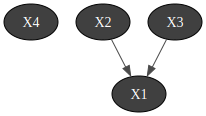

In [314]:


cbn = gum.fastBN("X1<-X2;X4;X1<-X3")
gnb.showBN(cbn)

In [315]:
data = pd.read_csv( "data/bn_data.csv" , sep=' ')
data

,X1,X2,X3,X4
0,0.56,0.48,0.60,0.05
1,0.46,0.40,0.45,0.26
2,0.58,0.62,0.69,0.76
3,0.45,0.57,0.52,0.44
4,0.35,0.69,0.46,0.69
...,...,...,...,...
994,0.64,0.22,0.57,0.54
995,0.37,0.62,0.46,0.93
996,0.52,0.46,0.53,0.16
997,0.36,0.57,0.42,0.51


#### Model 2

In [316]:
def generate_data(n_samples: int = 1000, intercept = 1, sigma = 0.2):
    # Generate independent variables
    
    # sample X2 from a normal distribution with center 1 and std 2

    X4 = np.random.randn(n_samples)
    X2 = np.random.randn(n_samples)
    X3 = np.random.randn(n_samples)
    
    # Generate X1 as a linear combination of X2 and X3 plus some Gaussian noise
    beta2, beta3 = 0.8, 0.9  # Arbitrarily chosen coefficients
    noise = np.random.randn(n_samples)*sigma # Gaussian noise with standard deviation 0.2
    X1 = intercept + beta2 * X2 + beta3 * X3 + noise
    
    # Combine into a dataframe
    df = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3})
    
    return df

# Generate a sample dataset
data2 = generate_data(n_samples = 2000, intercept=1, sigma=0.05)
data2.head()

# TODO: you need to recover the betas


,X1,X2,X3
0,-1.015269,0.040090,-2.384778
1,2.615389,1.091185,0.760145
2,1.681411,0.677289,0.049767
3,1.257322,0.136184,0.203334
4,0.309292,-0.656395,-0.219630


In [317]:
# compute theoretical marginal likelihood: for each model, compute the marginal likelihood of the data, and then normalize across all DAGs
all_dags_2, total_score_2 = generate_all_dags( data2 )

print( "total score: ", total_score_2 )

min score -8912.23564415564
max score -2827.3045318477903
total_score_normalised = 1.0
total score:  1.5449882997386726


In [318]:
all_dags_2["15"]

{'DAG': <networkx.classes.digraph.DiGraph at 0x2cf3bde90>,
 'log_score': -92.10800096099274,
 'params': {'X2': {'Lambda_n': array([[2000.1]]),
   'm_n': array([-0.0323871]),
   'a_n': 1001.0,
   'b_n': 1010.9377360170404},
  'X1': {'Lambda_n': array([[2000.1       ,  -64.77743533,    5.41358473],
          [ -64.77743533, 2022.0734252 ,   29.25207037],
          [   5.41358473,   29.25207037, 1959.13052747]]),
   'm_n': array([0.9992349 , 0.80107203, 0.90142765]),
   'a_n': 1001.0,
   'b_n': 3.653208639624154},
  'X3': {'Lambda_n': array([[2000.1]]),
   'm_n': array([0.00270666]),
   'a_n': 1001.0,
   'b_n': 980.5079373777185}},
 'score': 9.954133099076527e-41,
 'score_normalised': 6.442853386501517e-41}

In [319]:
all_dags_2["20"]

{'DAG': <networkx.classes.digraph.DiGraph at 0x2cf51db10>,
 'log_score': -0.6069909529187498,
 'params': {'X1': {'Lambda_n': array([[2000.1]]),
   'm_n': array([0.97573036]),
   'a_n': 1001.0,
   'b_n': 1468.989851919527},
  'X2': {'Lambda_n': array([[2000.1       , 1951.55828473,    5.41358473],
          [1951.55828473, 4840.27436345, 1794.85689245],
          [   5.41358473, 1794.85689245, 1959.13052747]]),
   'm_n': array([-1.24232474,  1.24314115, -1.12053941]),
   'a_n': 1001.0,
   'b_n': 5.1449659391234945},
  'X3': {'Lambda_n': array([[2000.1       , 1951.55828473],
          [1951.55828473, 4840.27436345]]),
   'm_n': array([-0.59201233,  0.60951162]),
   'a_n': 1001.0,
   'b_n': 435.12465309145466}},
 'score': 0.5449882997386726,
 'score_normalised': 0.3527459074161628}

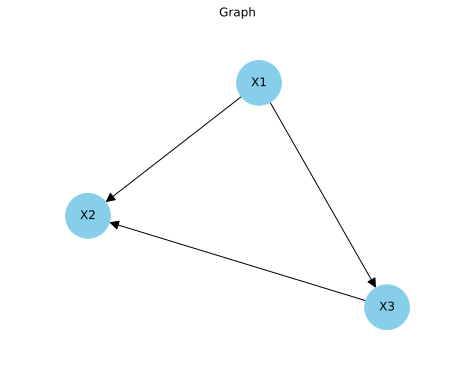

In [320]:
plot_graph( all_dags_2["20"]["DAG"] )

In [321]:
all_dags_2

{'0': {'DAG': <networkx.classes.digraph.DiGraph at 0x2cf469850>,
  'log_score': -6084.93111230785,
  'params': {'X1': {'Lambda_n': array([[2000.1]]),
    'm_n': array([0.97573036]),
    'a_n': 1001.0,
    'b_n': 1468.989851919527},
   'X2': {'Lambda_n': array([[2000.1]]),
    'm_n': array([-0.0323871]),
    'a_n': 1001.0,
    'b_n': 1010.9377360170404},
   'X3': {'Lambda_n': array([[2000.1]]),
    'm_n': array([0.00270666]),
    'a_n': 1001.0,
    'b_n': 980.5079373777185}},
  'score': 0.0,
  'score_normalised': 0.0},
 '1': {'DAG': <networkx.classes.digraph.DiGraph at 0x2cf3ebe50>,
  'log_score': -2655.6341854750085,
  'params': {'X1': {'Lambda_n': array([[2000.1]]),
    'm_n': array([0.97573036]),
    'a_n': 1001.0,
    'b_n': 1468.989851919527},
   'X2': {'Lambda_n': array([[2000.1       , 1951.55828473],
           [1951.55828473, 4840.27436345]]),
    'm_n': array([-0.57895159,  0.56015936]),
    'a_n': 1001.0,
    'b_n': 550.2983783502953}},
  'score': 0.0,
  'score_normalised': 0

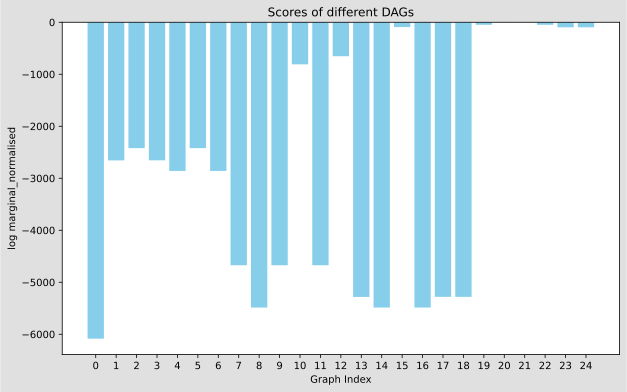

In [322]:

# Extracting keys and scores
keys = list(all_dags_2.keys())
scores = [all_dags_2[key]["log_score"] for key in keys]


# Plotting
plt.figure(figsize=(10,6))
plt.bar(keys, scores, color='skyblue')
plt.xlabel('Graph Index')
plt.ylabel('log marginal_normalised')
plt.title('Scores of different DAGs')
plt.show()


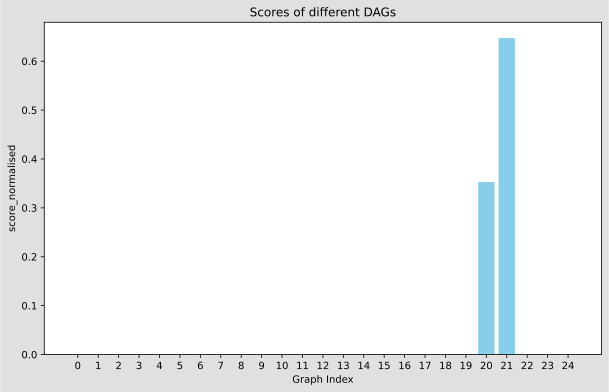

In [323]:

# Extracting keys and scores
keys = list(all_dags_2.keys())
scores = [all_dags_2[key]["score_normalised"] for key in keys]

# Plotting
plt.figure(figsize=(10,6))
plt.bar(keys, scores, color='skyblue')
plt.xlabel('Graph Index')
plt.ylabel('score_normalised')
plt.title('Scores of different DAGs')
plt.show()

In [324]:
ID = 15
sample_parameters( all_dags_2[str(ID)]["params"] )

{'X2': {'beta': -0.03549779157429113, 'sigma2': 1.0515833029766273},
 'X1': {'beta': array([1.00147061, 0.79992213, 0.90198537]),
  'sigma2': 0.0036756937091788878},
 'X3': {'beta': 0.019064345739761637, 'sigma2': 0.9751988022033851}}

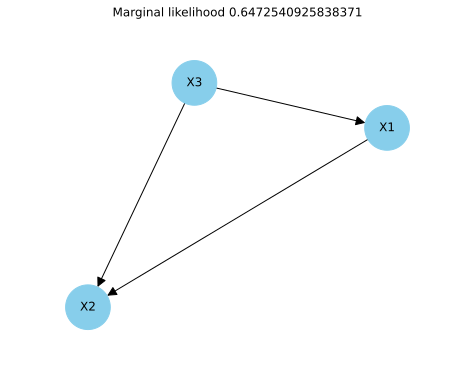

In [325]:
ID = 21
plot_graph(all_dags_2[str(ID)]["DAG"], f'Marginal likelihood { all_dags_2[str(ID)]["score_normalised"]}')

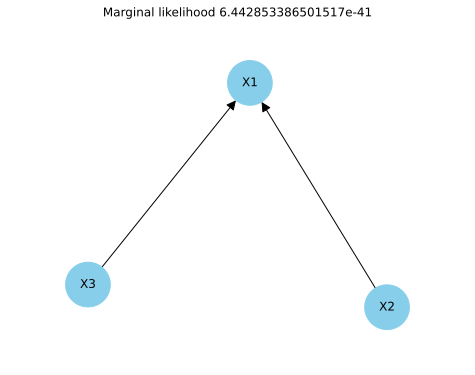

In [326]:
ID = 15
plot_graph(all_dags_2[str(ID)]["DAG"], f'Marginal likelihood { all_dags_2[str(ID)]["score_normalised"]}')

In [327]:
#for ID in range(0, len(all_dags_2.keys())):
#    plot_graph(all_dags_2[str(ID)]["DAG"], f'Marginal likelihood { all_dags_2[str(ID)]["score_normalised"]}')
    

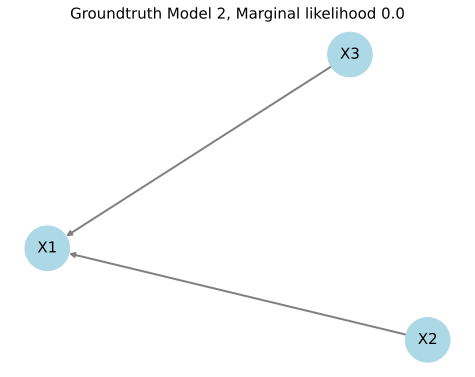

In [328]:
# compute the true marginal likelihood of the groundtruth graph
model2 = nx.DiGraph()
model2.add_edges_from([('X2', 'X1'), ('X3', 'X1')])
nx.draw(model2, with_labels=True, node_size=2000, node_color='lightblue', font_size=15, width=2, edge_color='gray')
# add a title
score, params =  compute_log_marginal_likelihood(data2, model2)
score = np.exp( score + 250 )
plt.title(f'Groundtruth Model 2, Marginal likelihood { score / total_score_2}', fontsize=15)

plt.show()

#### Model 3


In [329]:
data = pd.read_csv('testdata.csv')

## Marginal Likelihood

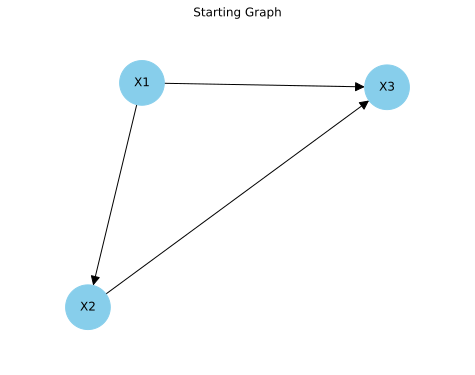

Starting MCMC...
Finished MCMC

Average Log Marginal Likelihood:  -2828.208964970663
Acceptance rate:  0.1928


In [330]:
NUM_ITERATIONS = 10000
DATA = data2

# create a dense directed acyclic graph
initial_graph = nx.DiGraph()
initial_graph.add_nodes_from(DATA.columns)
for i in range(0, len(DATA.columns)):
    for j in range(i+1, len(DATA.columns)):
        initial_graph.add_edge(DATA.columns[i], DATA.columns[j])
        
plot_graph(initial_graph, "Starting Graph")

print("Starting MCMC...")
posteriors, graph_candidates, Gs, graphs, marginals, operations = structured_MCMC(DATA, initial_graph, NUM_ITERATIONS, score_function = "Log_Marginal_Likelihood", restart_freq=100)
print("Finished MCMC")

print()
print("Average Log Marginal Likelihood: ", np.mean(posteriors["marginal_likelihood"]))
print("Acceptance rate: ", posteriors['acceptance_rate'])


In [331]:
# get index of the maximum value in posterior
max_index = np.argmax(posteriors['marginal_likelihood'])
#plot_graph(graph_candidates[max_index])


tdo: add color when it is accepted in the trace plot
make 20 obs
two nodes / three nodes
make the brute
if time: show the evolution of the MCMC

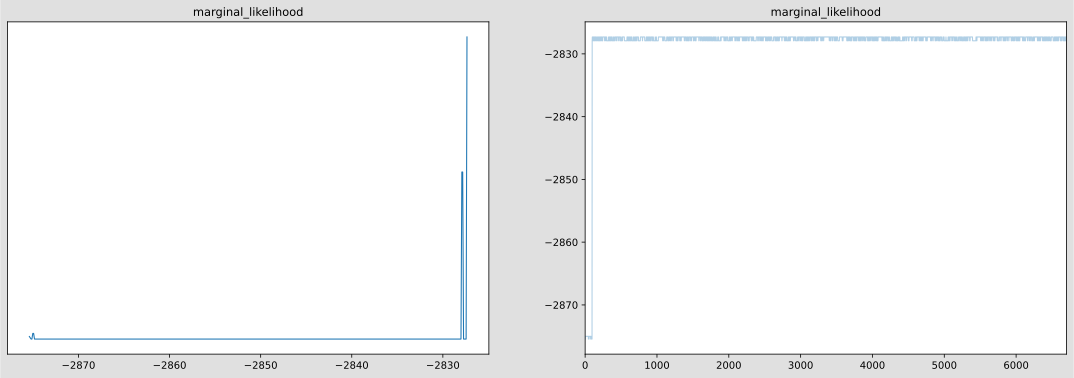

In [332]:
az.plot_trace(posteriors, var_names=["marginal_likelihood"], figsize=(19, 6));


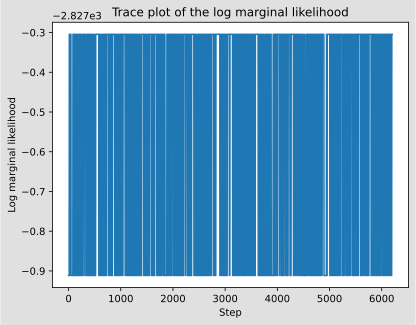

<Figure size 1000x1000 with 0 Axes>

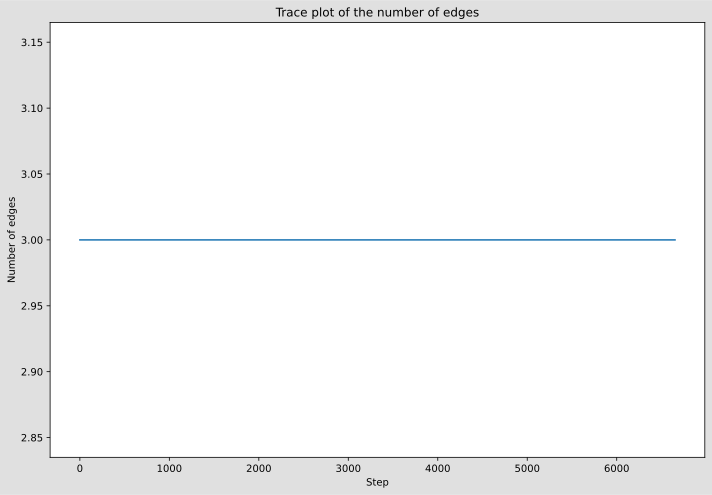

In [336]:
plot_trace(posteriors, burnit = 500, figsize=(10, 10));
plot_edges_trace( graph_candidates[50:], figsize=(10, 7))

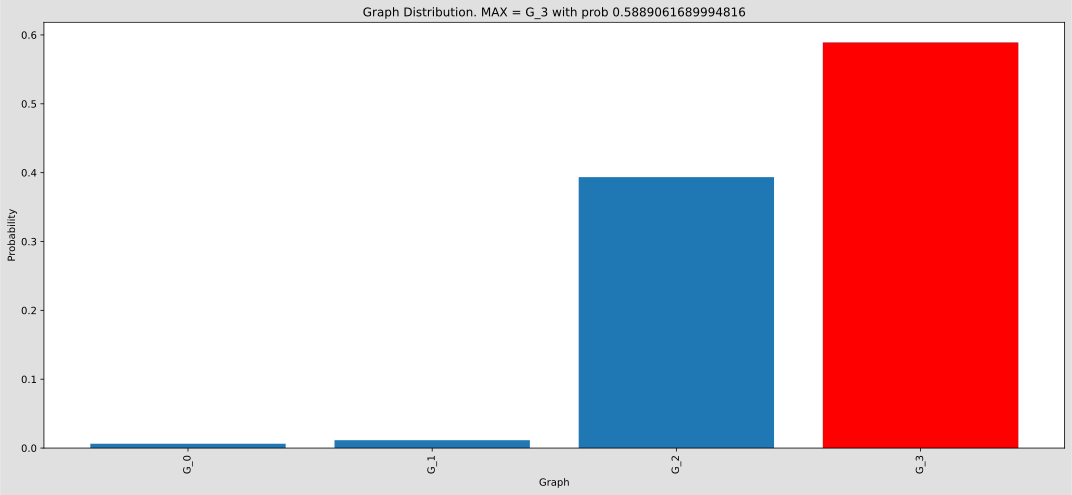

In [334]:
max_labels, max_freq = plot_graph_distribution( normalise_Gs(Gs) )

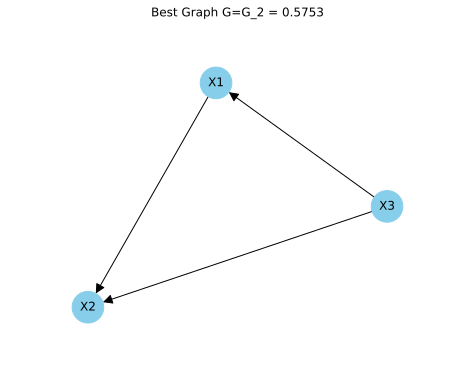

In [272]:
for label in max_labels:
    plot_graph( graphs[label], f"Best Graph G={label} = {np.round(max_freq,4)}", node_size = 1000)

### Debugging

In [273]:
graphs

{'G_0': <networkx.classes.digraph.DiGraph at 0x2c2ca7750>,
 'G_1': <networkx.classes.digraph.DiGraph at 0x2c2aa0790>,
 'G_2': <networkx.classes.digraph.DiGraph at 0x2c2ee1f50>}

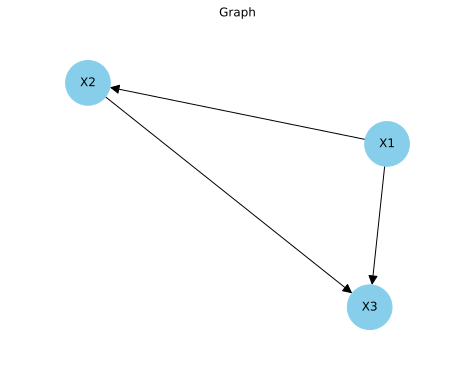

In [274]:
G_current = graphs["G_0"]
plot_graph( G_current )

add_edge


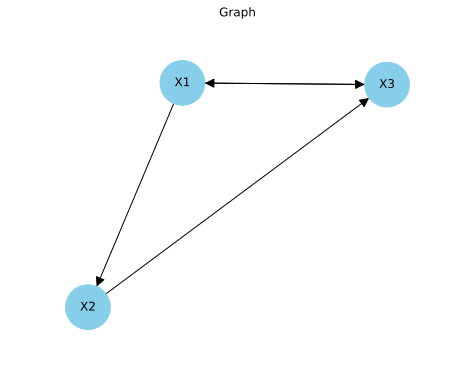

In [275]:
G_proposed, operation = propose_new_graph(G_current)
print(operation)
plot_graph(G_proposed)

delete_edge


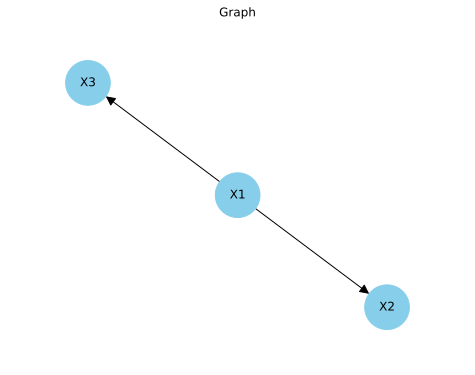

In [276]:
G_proposed, operation = propose_new_graph(G_current)
print(operation)
plot_graph(G_proposed)

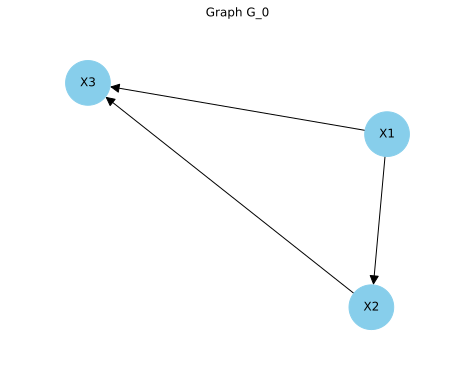

Operation:  reverse_edge


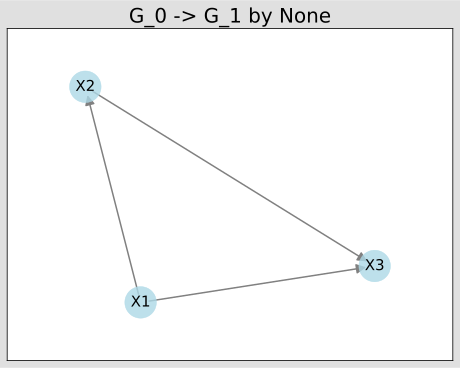

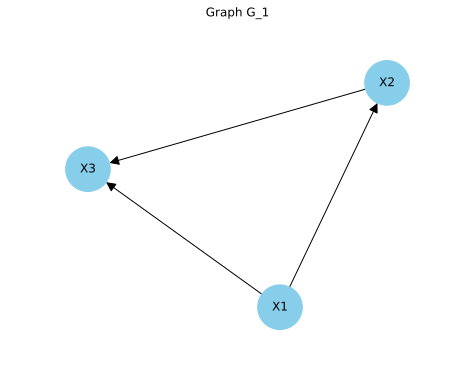

{'X1': {'X2': {}, 'X3': {}}, 'X2': {'X3': {}}, 'X3': {}}
Operation:  reverse_edge


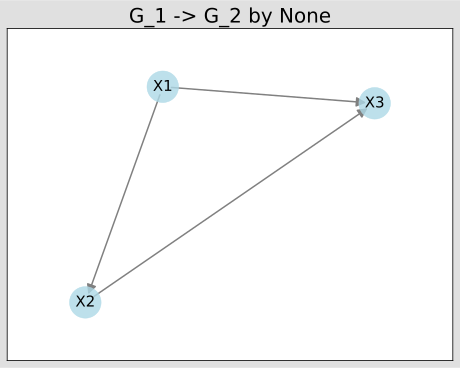

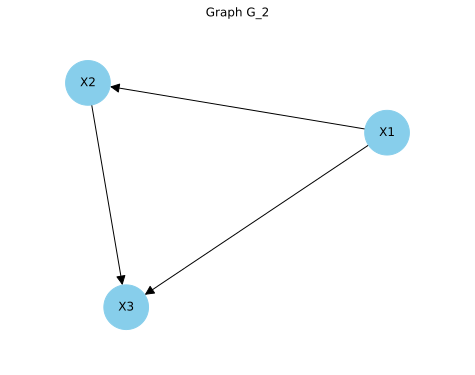

{'X1': {'X2': {}, 'X3': {}}, 'X2': {'X3': {}}, 'X3': {}}
Operation:  reverse_edge


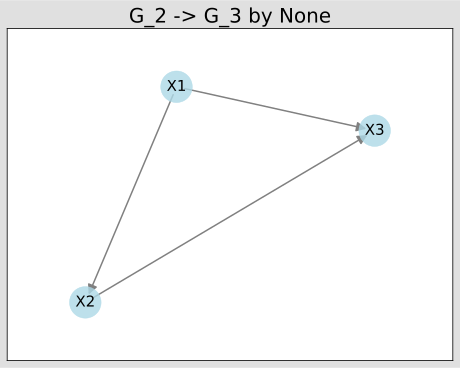

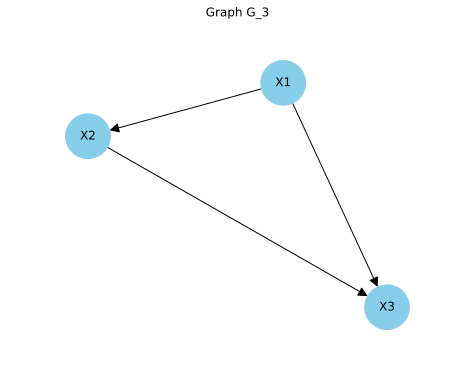

{'X1': {'X2': {}, 'X3': {}}, 'X2': {'X3': {}}, 'X3': {}}
Operation:  reverse_edge


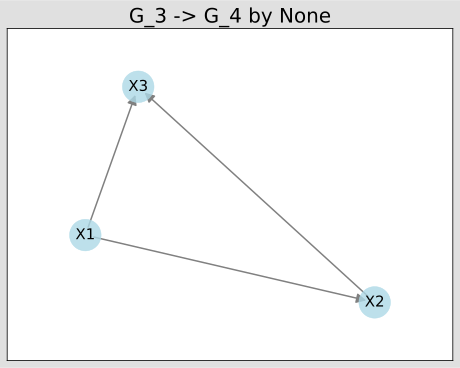

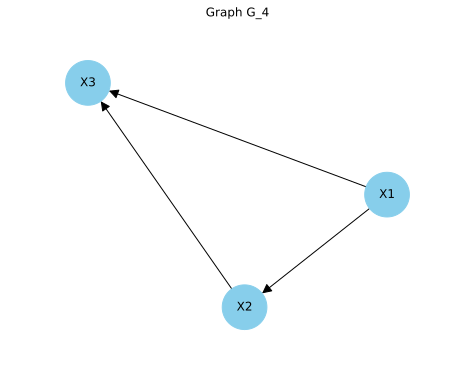

{'X1': {'X2': {}, 'X3': {}}, 'X2': {'X3': {}}, 'X3': {}}
Operation:  reverse_edge


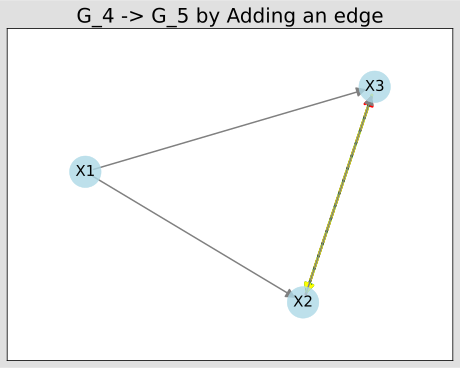

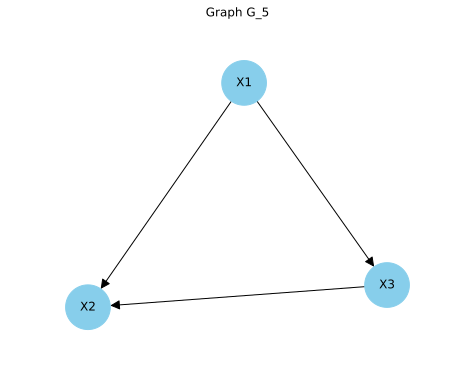

{'X1': {'X2': {}, 'X3': {}}, 'X2': {}, 'X3': {'X2': {}}}
Operation:  reverse_edge


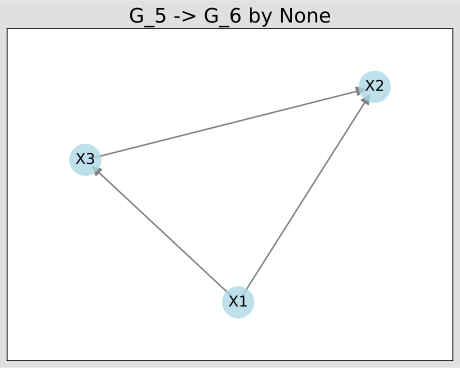

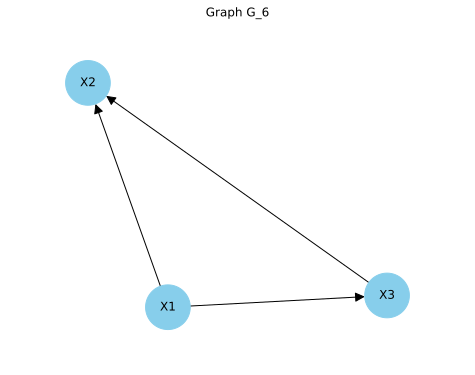

{'X1': {'X3': {}, 'X2': {}}, 'X2': {}, 'X3': {'X2': {}}}
Operation:  reverse_edge


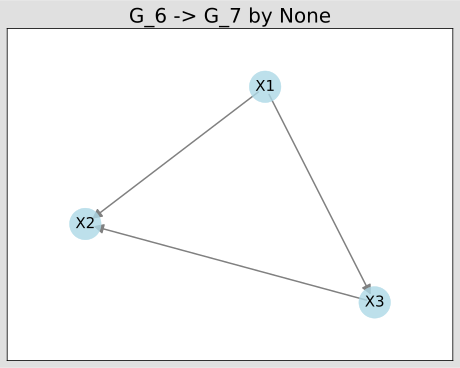

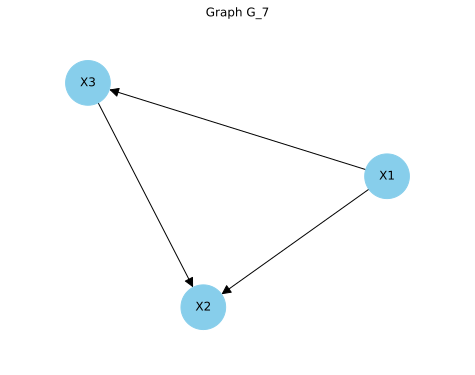

{'X1': {'X3': {}, 'X2': {}}, 'X2': {}, 'X3': {'X2': {}}}
Operation:  reverse_edge


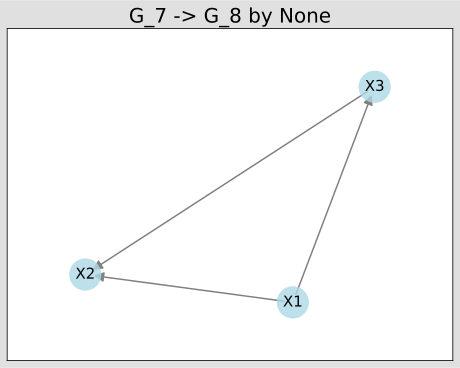

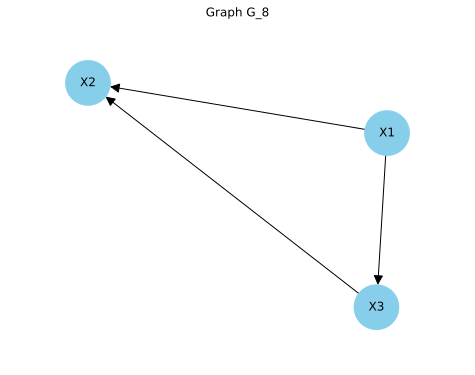

{'X1': {'X3': {}, 'X2': {}}, 'X2': {}, 'X3': {'X2': {}}}
Operation:  reverse_edge


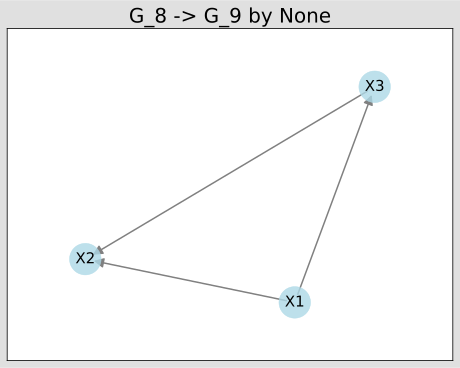

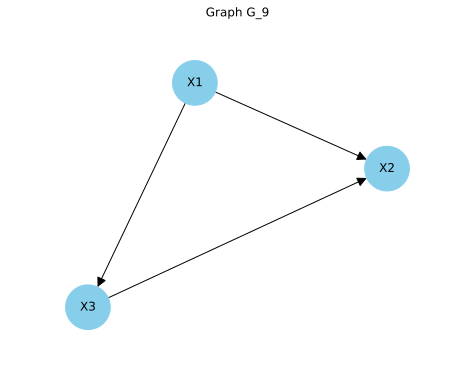

{'X1': {'X3': {}, 'X2': {}}, 'X2': {}, 'X3': {'X2': {}}}


In [277]:
# Example usage:
# G1 = nx.DiGraph([('X2', 'X1'), ('X3', 'X1')])
# G2 = nx.DiGraph([('X1', 'X2'), ('X3', 'X1')])
# plot_graph_transition(G1, G2)

graph_t0 = graph_candidates[0]
plot_graph(graph_t0, "Graph G_0")

for i in range(1, 10):
    graph_t1 = graph_candidates[i]
    operation = operations[i]
    print("Operation: ", operation)
    g_out = plot_graph_transition(graph_t0, graph_t1, i)
    graph_t0 = graph_t1
    plot_graph(graph_t1, f"Graph G_{i}")
    print(graph_t1.adj)
    

## BIC Score Example

In [283]:

# start with all nodes independet from each other
# initial_graph = nx.DiGraph()
# initial_graph.add_nodes_from(data.columns)

posteriors_bic, graph_candidates_bic, Gs_bic, graphs_bic, marginals_bic, operations_bic = structured_MCMC(DATA, initial_graph, NUM_ITERATIONS, score_function = "BIC", restart_freq=100)

A = 0.9862 	 u = 0.3401 	 u < A = True
A = 0.7551 	 u = 0.0104 	 u < A = True
A = -0.1381 	 u = 0.4816 	 u < A = False
A = 1 	 u = 0.4782 	 u < A = True
A = -0.0972 	 u = 0.991 	 u < A = False
A = 0.7446 	 u = 0.7489 	 u < A = False
A = 0.969 	 u = 0.5452 	 u < A = True
A = 1 	 u = 0.3936 	 u < A = True


In [284]:
print(posteriors_bic['acceptance_rate'])

0.5


In [285]:
print(np.mean(posteriors_bic['marginal_likelihood']))

-12520.558602091613


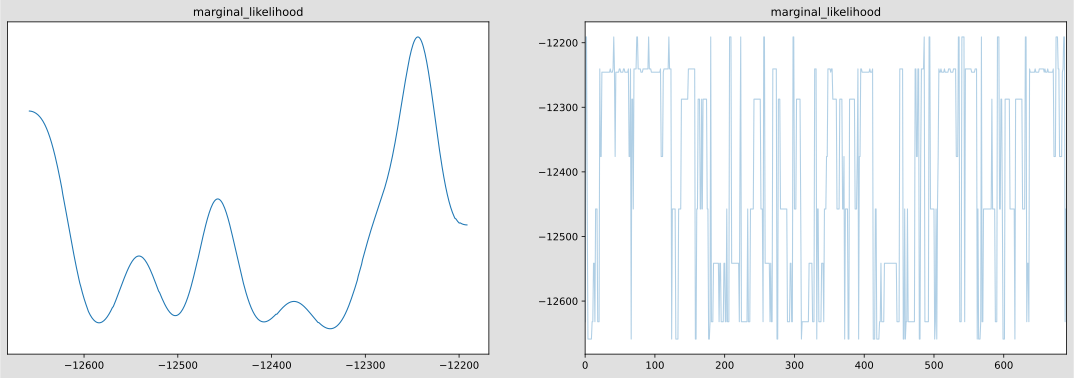

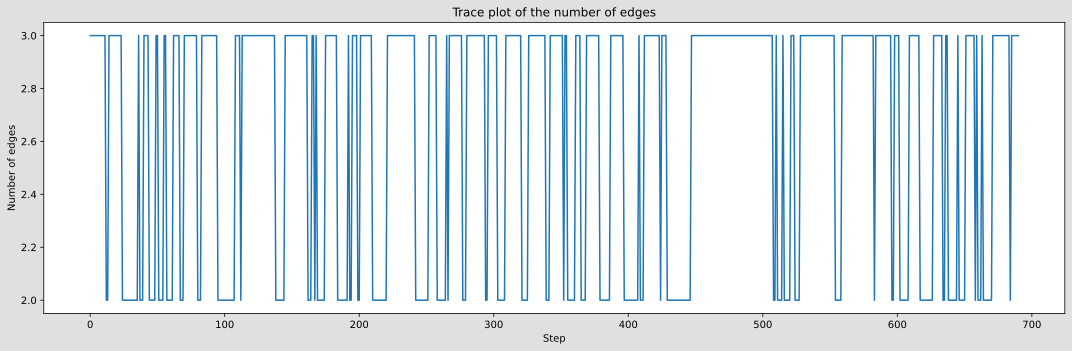

In [249]:
az.plot_trace(posteriors_bic, var_names=["marginal_likelihood"], figsize=(19, 6));
plot_edges_trace( graph_candidates_bic)

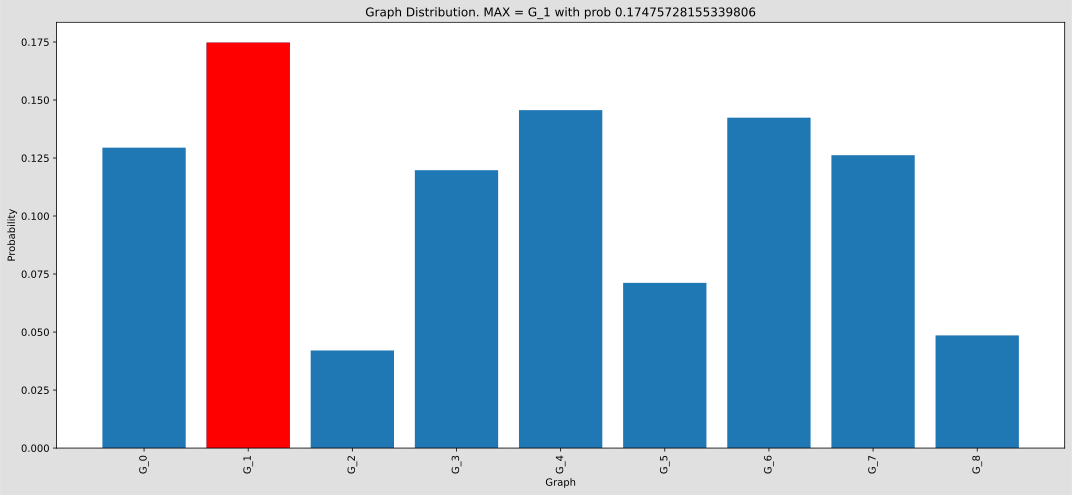

In [250]:
max_labels, max_freq = plot_graph_distribution( normalise_Gs(Gs_bic) )

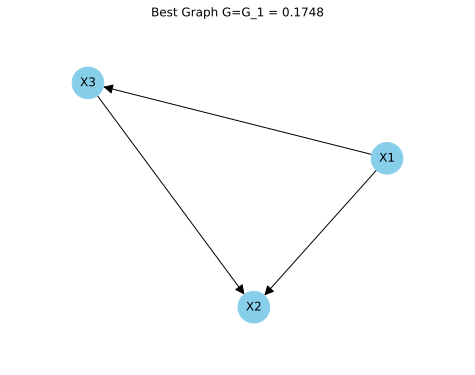

In [251]:
for label in max_labels:
    plot_graph( graphs_bic[label], f"Best Graph G={label} = {np.round(max_freq,4)}", node_size = 1000)

In [253]:

# start with all nodes independet from each other
# initial_graph = nx.DiGraph()
# initial_graph.add_nodes_from(data.columns)

posteriors_aic, graph_candidates_aic, Gs_aic, graphs_aic, marginals_aic, operations_aic = structured_MCMC(DATA, initial_graph, NUM_ITERATIONS, score_function = "AIC", restart_freq=100)

In [254]:
print(posteriors_aic['acceptance_rate'])


0.338


In [255]:
print(np.mean(posteriors_bic['marginal_likelihood']))

-12398.32783719744


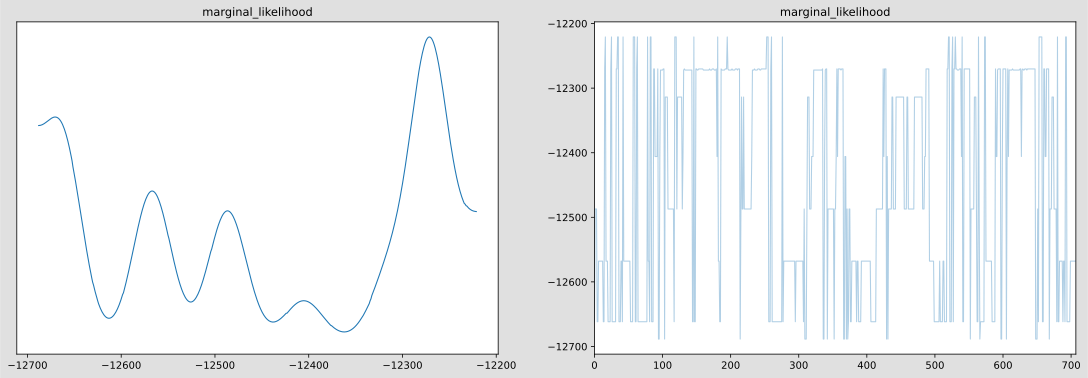

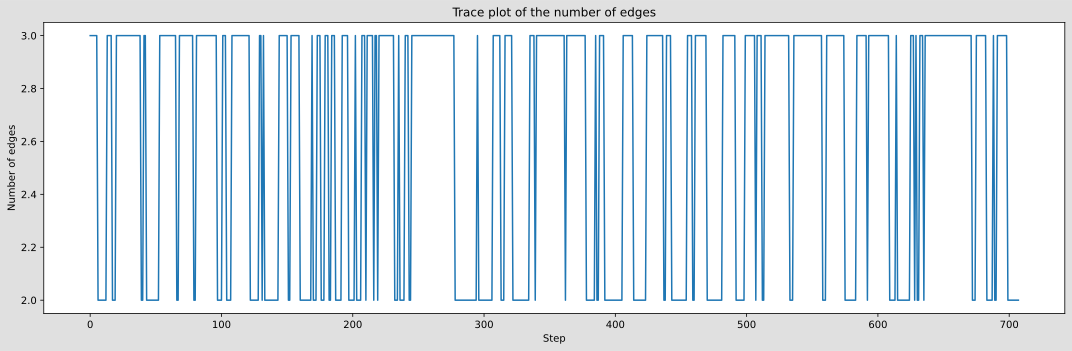

In [256]:
az.plot_trace(posteriors_aic, var_names=["marginal_likelihood"], figsize=(19, 6));
plot_edges_trace( graph_candidates_aic)

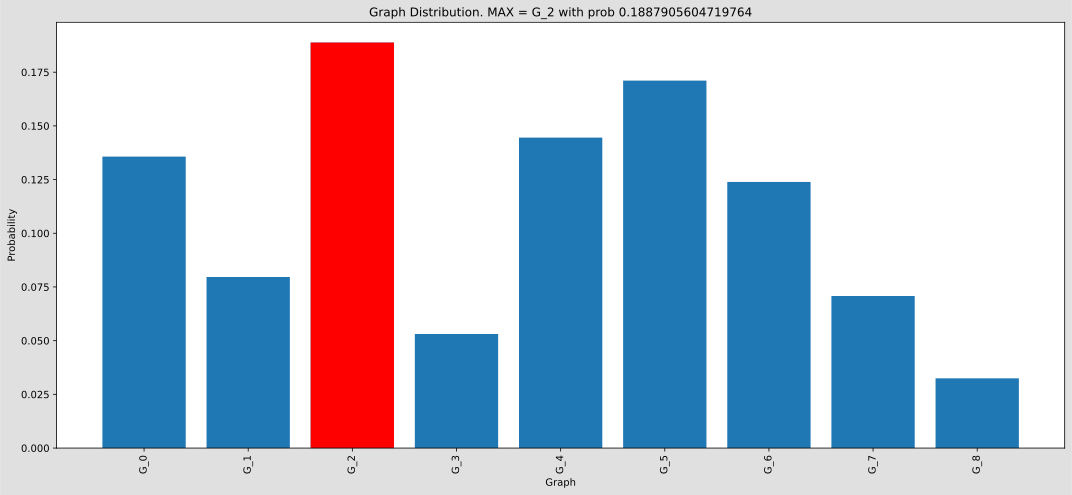

In [257]:
max_labels, max_freq = plot_graph_distribution( normalise_Gs(Gs_aic) )

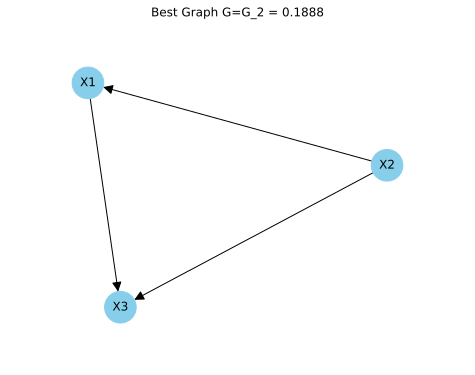

In [258]:
for label in max_labels:
    plot_graph( graphs_aic[label], f"Best Graph G={label} = {np.round(max_freq,4)}", node_size = 1000)